**Aim**: Predict the outcome of heart attack using XGboost.<br>
Dataset : The dataset is extracted from https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset?sort=published <br>

Features: <br>
- **Age** : Age of the patient <br>
- **Sex** : Sex of the patient <br>
- **cp** : Chest Pain type chest pain type. 0 = Typical Angina, 1 = Atypical Angina, 2 = Non-anginal Pain, 3 = Asymptomatic. <br> 
- **trtbps** : resting blood pressure (in mm Hg) <br>
- **chol** : cholestoral in mg/dl fetched via BMI sensor <br>
- **fbs** : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) <br>
- **rest_ecg** : resting electrocardiographic results. 0= normal, 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV),
2 = showing probable or definite left ventricular hypertrophy by Estes' criteria <br>
- **thalach** : maximum heart rate achieved <br>
- **exang** : exercise induced angina (1 = yes; 0 = no) <br>
- **oldpeak** - Previous peak <br>
- **slp** - Slope <br>
- **caa** : number of major vessels (0-3) <br>
- **thall** - Thalium Stress Test result ~ (0,3) <br>
- **output** : 0= less chance of heart attack 1= more chance of heart attack

## Table of Contents
- [1. Import Packages](#1)
- [2. Load Data](#2)
- [3. Exploratory Data Analysis](#3)
- [4. Data Preprocessing](#4)


<a name='1'></a>
## 1.  Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<a name='2'></a>
## 2. Load Data

In [2]:
data = pd.read_csv('Data/heart.csv')

<a name='3'></a>
##  3. Exploratory Data Analysis

In [3]:
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
print("The shape of the dataset is : ", data.shape)

The shape of the dataset is :  (303, 14)


In [5]:
categorical_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
continuous_cols = ["age","trtbps","chol","thalachh","oldpeak"]
target_col = ["output"]
print("The categorial cols are : ", categorical_cols)
print("The continuous cols are : ", continuous_cols)
print("The target variable is :  ", target_col)

The categorial cols are :  ['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall']
The continuous cols are :  ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
The target variable is :   ['output']


#### count plot for categorical features

/Users/alishaangdembe/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


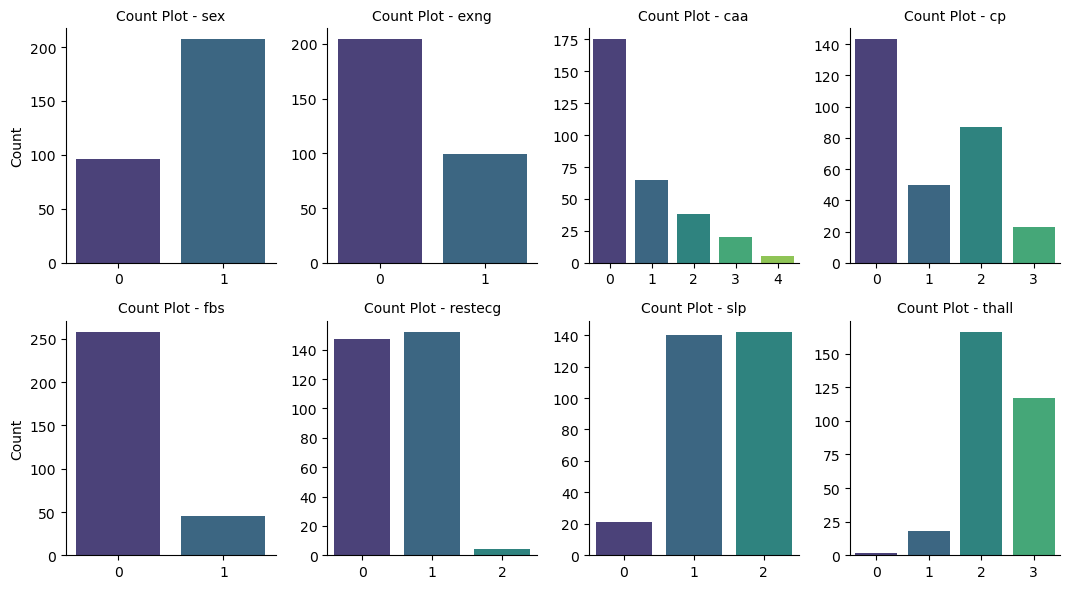

In [6]:
g = sns.catplot(
    data=data[categorical_cols].melt(),
    x="value",
    col="variable",
    kind="count",
    col_wrap=4,
    palette="viridis",
    height=3,
    aspect=0.9,
    sharex=False,
    sharey=False,
)

# Set titles and labels for each plot
g.set_titles("Count Plot - {col_name}")
g.set_xlabels("")
g.set_ylabels("Count")

plt.tight_layout()
plt.show()


#### Histogram and pairwise correlation of continuous features

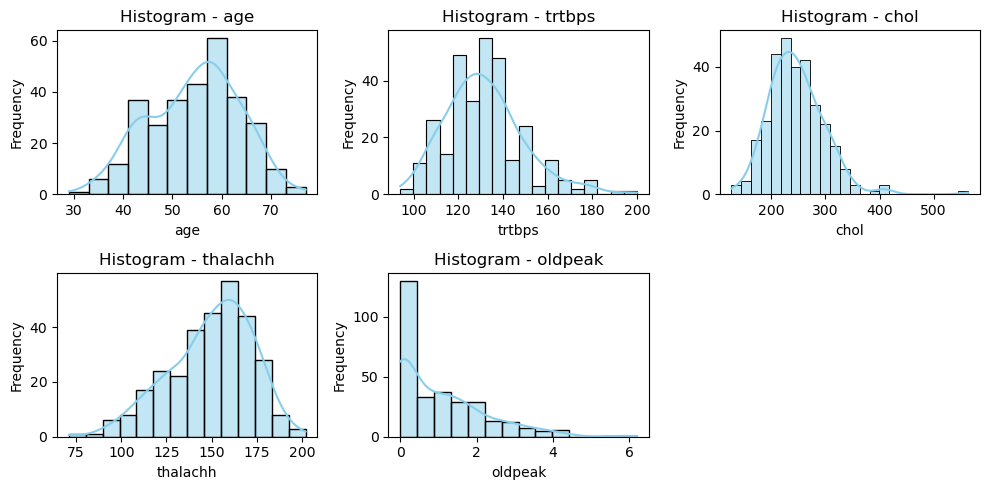

<Figure size 1000x500 with 0 Axes>

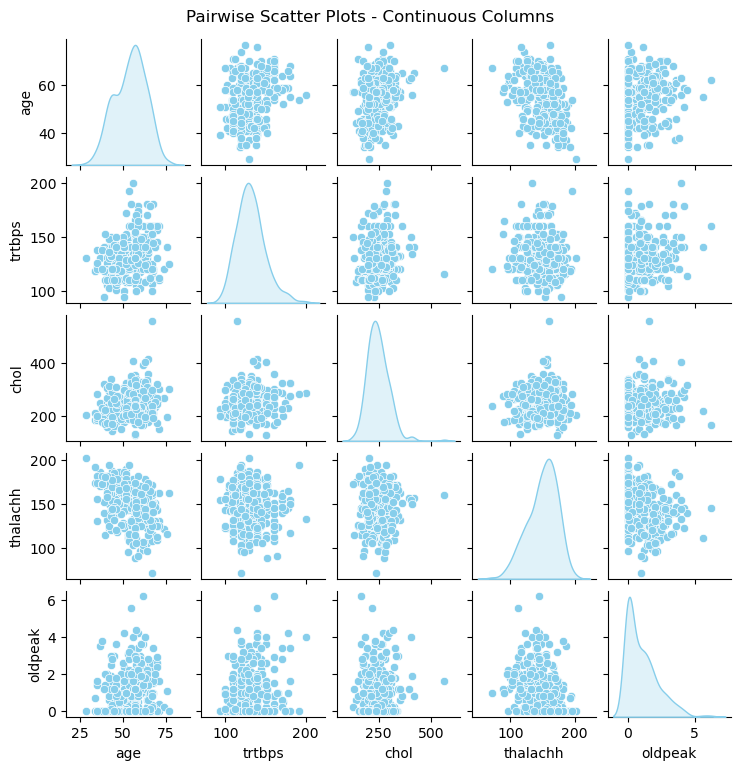

In [7]:
# Plot histogram for each continuous column
plt.figure(figsize=(10, 5))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=data, x=col, kde=True, color='skyblue')
    plt.title(f"Histogram - {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot scatter plot for pairwise continuous columns
plt.figure(figsize=(10, 5))
sns.pairplot(data[continuous_cols], diag_kind="kde", plot_kws={"color": "skyblue"}, diag_kws={"color": "skyblue"}, height=1.5)
plt.suptitle("Pairwise Scatter Plots - Continuous Columns", y=1.02)
plt.show()


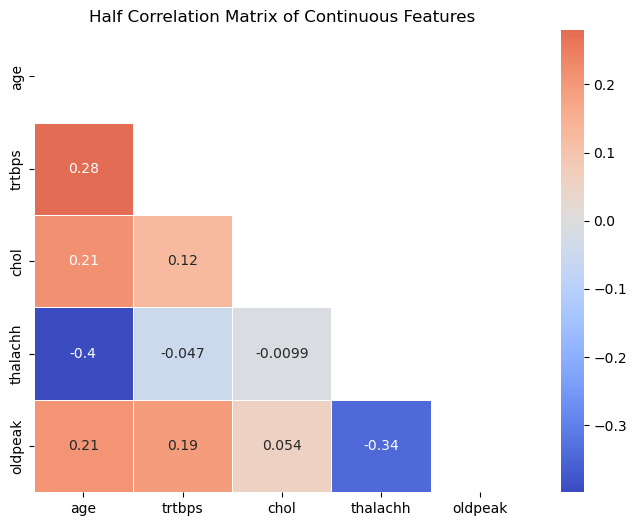

In [8]:
# Compute the correlation matrix
correlation_matrix = data[continuous_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5, mask=mask)
plt.title("Half Correlation Matrix of Continuous Features")
plt.show()

#### Distribution of features by the output label

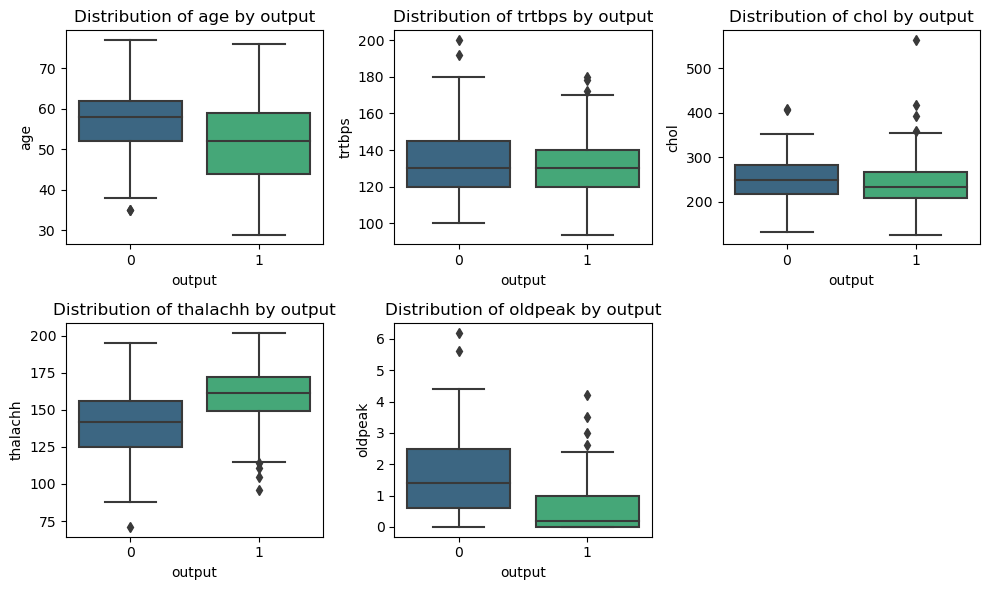

In [9]:
# Separate data by output
df = data[continuous_cols + target_col].copy()
df_outcome_0 = df[df["output"] == 0]
df_outcome_1 = df[df["output"] == 1]

# Plot distribution for each column by outcome using boxplots
plt.figure(figsize=(10, 6))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="output", y=col, data=df, palette="viridis")
    plt.title(f"Distribution of {col} by output")
    plt.xlabel("output")
    plt.ylabel(col)
plt.tight_layout()
plt.show()

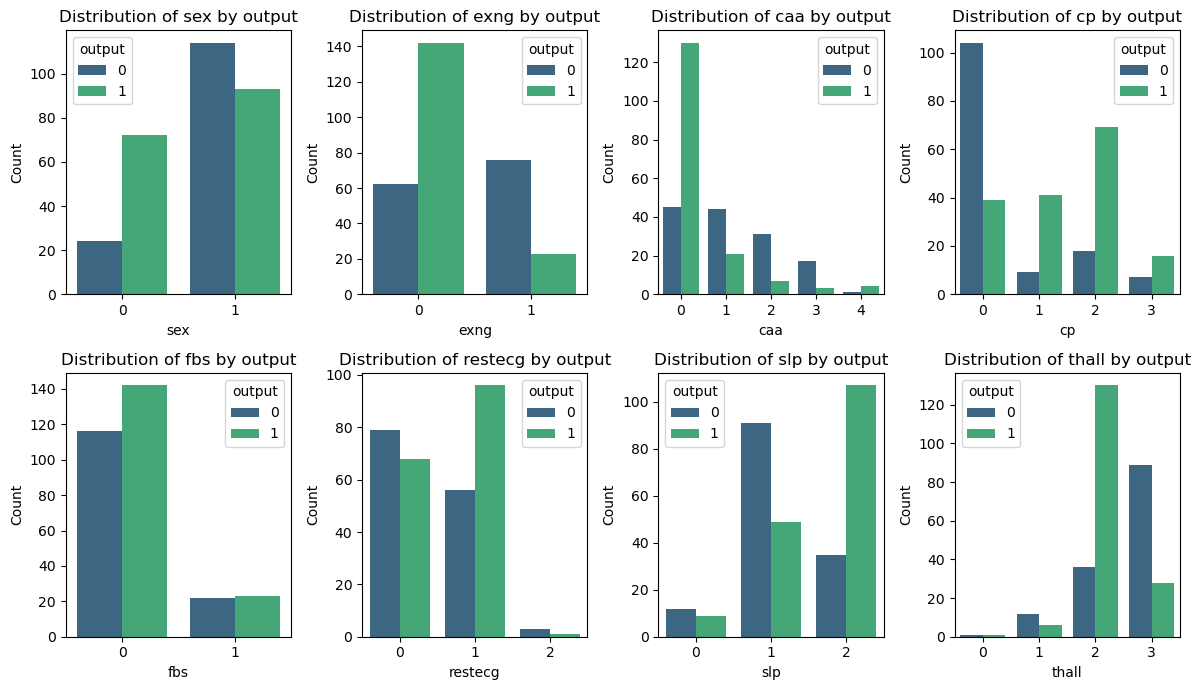

In [11]:
# Plot count plot for each categorical column by outcome
plt.figure(figsize=(12, 7))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 4, i)
    sns.countplot(x=col, hue='output', data=data, palette='viridis')
    plt.title(f'Distribution of {col} by output')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='output', labels=['0', '1'])
plt.tight_layout()
plt.show()

#### Pairplot by output label

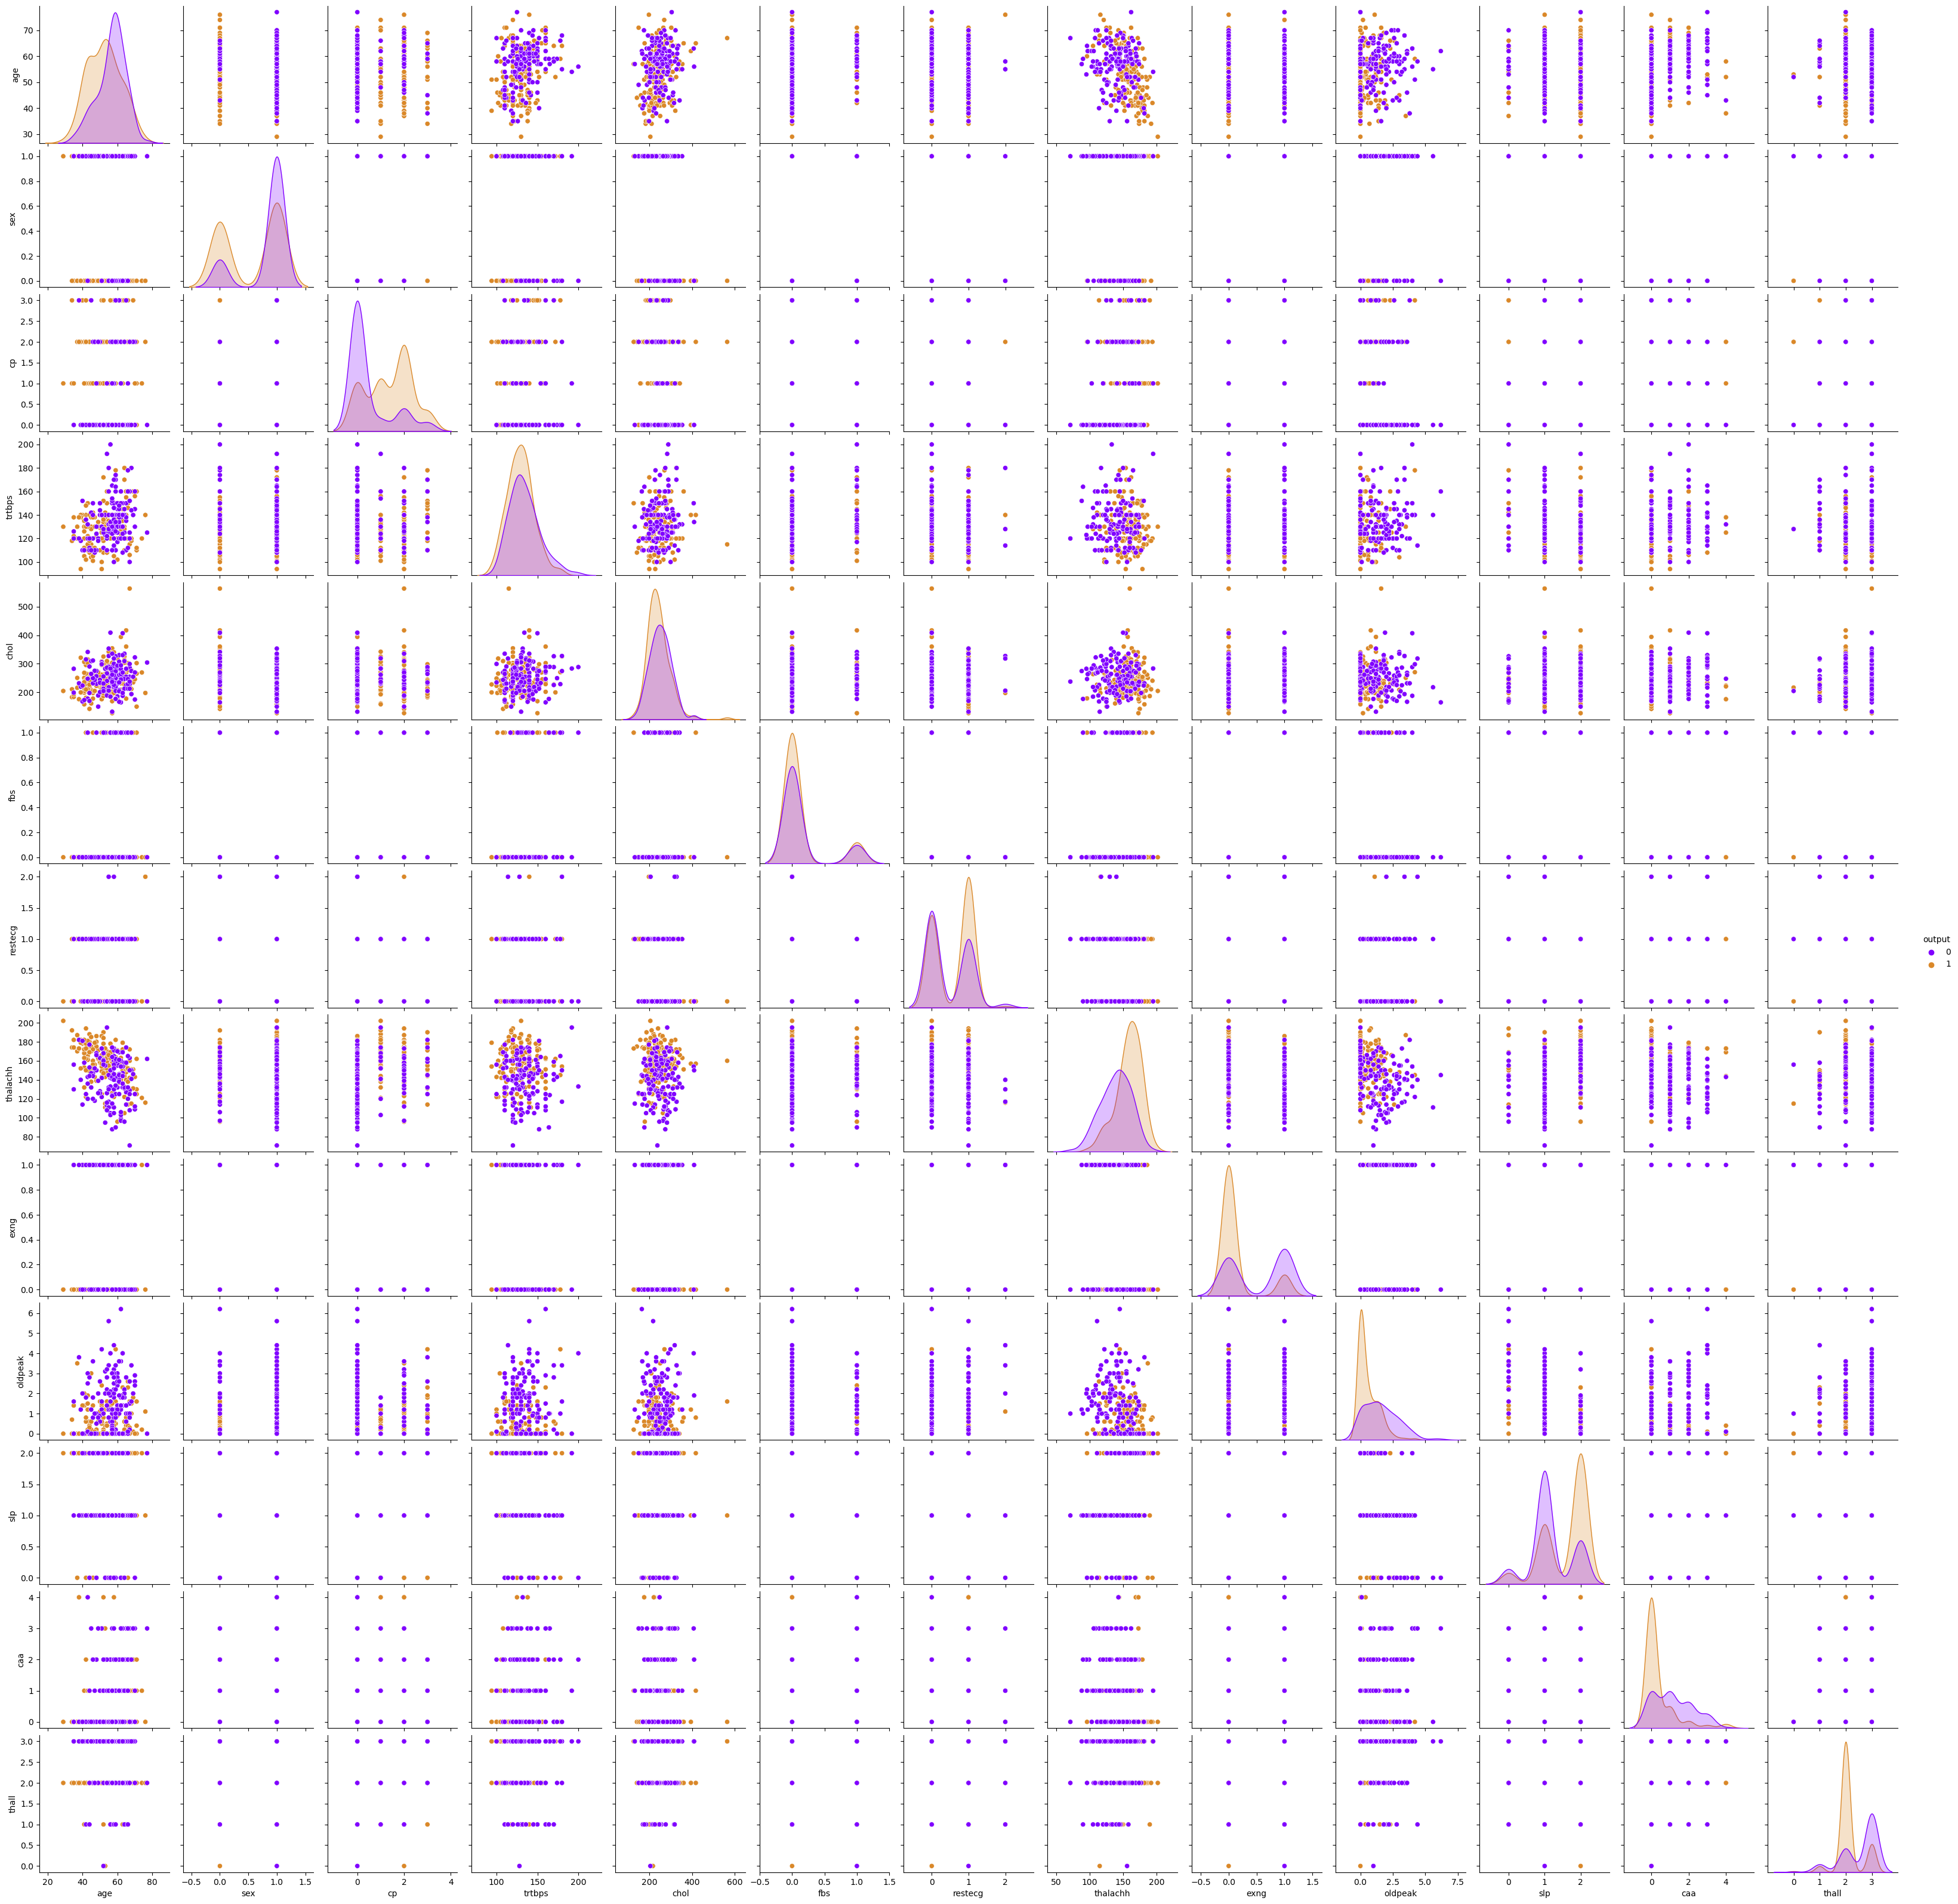

In [12]:
sns.pairplot(data,hue='output',palette = ["#8000ff","#da8829"])
plt.show()

<a name='4'></a>
##  4. Data Preprocessing

In [13]:
from sklearn.preprocessing import RobustScaler

ImportError: dlopen(/Users/alishaangdembe/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/_arpack.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/libquadmath.0.dylib
  Referenced from: /Users/alishaangdembe/opt/anaconda3/lib/libgfortran.5.dylib
  Reason: tried: '/Users/alishaangdembe/opt/anaconda3/lib/libquadmath.0.dylib' (no such file), '/Users/alishaangdembe/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/../../../../../../../libquadmath.0.dylib' (no such file), '/Users/alishaangdembe/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/../../../../../../../libquadmath.0.dylib' (no such file), '/Users/alishaangdembe/opt/anaconda3/bin/../lib/libquadmath.0.dylib' (no such file), '/Users/alishaangdembe/opt/anaconda3/bin/../lib/libquadmath.0.dylib' (no such file), '/usr/local/lib/libquadmath.0.dylib' (no such file), '/usr/lib/libquadmath.0.dylib' (no such file)

In [ ]:
encoded_df = data.copy()

# encoding the categorical columns
encoded_df = pd.get_dummies(encoded_df, columns = categorical_cols, drop_first = True)

# defining the features and target
X = encoded_df.drop(['output'],axis=1)
y = encoded_df[['output']]

# scaling the continuous featuree
X[con_cols] = RobustScaler().fit_transform(X[continuous_cols])
X.head()

In [67]:
encoded_df

,age,trtbps,chol,thalachh,oldpeak,output,sex_1,exng_1,caa_1,caa_2,...,cp_2,cp_3,fbs_1,restecg_1,restecg_2,slp_1,slp_2,thall_1,thall_2,thall_3
0,63,145,233,150,2.3,1,1,0,0,0,...,0,1,1,0,0,0,0,1,0,0
1,37,130,250,187,3.5,1,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
2,41,130,204,172,1.4,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,56,120,236,178,0.8,1,1,0,0,0,...,0,0,0,1,0,0,1,0,1,0
4,57,120,354,163,0.6,1,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,140,241,123,0.2,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,1
299,45,110,264,132,1.2,0,1,0,0,0,...,0,1,0,1,0,1,0,0,0,1
300,68,144,193,141,3.4,0,1,0,0,1,...,0,0,1,1,0,1,0,0,0,1
301,57,130,131,115,1.2,0,1,1,1,0,...,0,0,0,1,0,1,0,0,0,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_test.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_test.shape)